**DenseNet**


DenseNet은 모든 Layer가 서로 연결되어 있는 구조이다. 각각의 Layer는 자신의 다음 단계의 Layer에만 output을 넘겨주는 것이 아니라, 이후의 모든 subLayer에 넘겨준다. DenseNet은 모든 Layer가 서로 연결되어 있기때문에 feature-map의 크기를 동일하게 일치시켜야한다. 총 N개의 Layer가 있을 때, i번째 Layer는 i개의 input을 갖게 되며, 총 connection 수는 N(N+1)/2 개인 Network가 된다.

DenseNet은 이러한 구조를 통해 vanishing gradient problem이나 parameter 수 감소등의 이점을 얻을 수 있다고 말한다. 아래 그림은 서로 연결된 DenseNet의 구조를 보여준다.

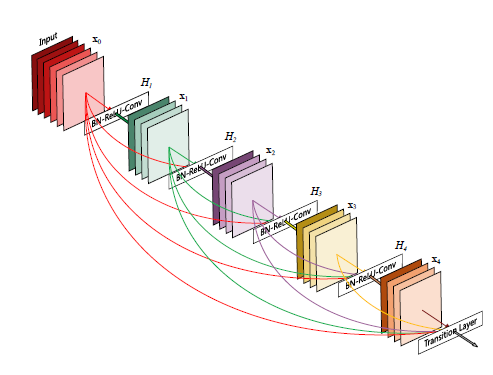

**Dense Connectivity**

Input을 x0라고 하고, L개의 Layer로 이루어진 네트워크를 생각해보자. 각각의 Layer는 Batch normalization(BN)과 ReLU, Pooling, 3x3 Convolution으로 이루어져있고, 이러한 구조 BN, ReLU, Conv를 합쳐서 composition function:  H( ) 라고 정의한다. 

i번째 Layer의 composition function은 $H_i$( )이고, 각 i번째 layer의 output은 $x_i$ 이라고 정의한다.


일반적인 **feed-forward Network**의 경우, i번째 Layer의 output은 

$x_i$ =  $H_i$( $x_{i-1}$ ) 이 된다.

**ResNet**의 경우, skip connection에 의해 현재 Layer의 input을 output에 추가하게 되므로, i번째 Layer의 output은 

$x_i$ =  $H_i$( $x_{i-1}$ ) + $x_{i-1}$ 이 된다. 이때 summation 방식으로 추가한다.

**DenseNet**의 경우, input x0를 포함해서 다른 모든 이전 Layer들의 output을 현재 Layer의 input으로 사용한다. ResNet과는 다르게 단순한 summation이 아닌 concatenate 방식을 통해 하나의 Tensor로 만든다. DenseNet의 i번째 Layer의 output은

$x_i$ = $H_l$( [ x0, x1, x2, . . . , $x_{i-1}$ ] ) 이 된다.


**DenseBlock**

Convoutional Network의 경우, pooling을 통해 down sampling을 해야 feature map의 크기를 조절할 수 있다. 하지만, 하나의 Dense connectivity 구조에서는 같은 feature map을 사용해야 하므로, pooling을 진행할 수가 없다.

이를 해결하기 위해서, DenseNet은 DenseBlock이라는 여러 개의 Dense Connectivity 구조로 나누었다. Denseblock마다 1x1 convolutional Layer와 2x2 Average Pooling을 적용하여 Down sampling을 하였다.

그림은 여러개의 DenseBlock으로 이루어진 DenseNet의 구조를 보여준다.

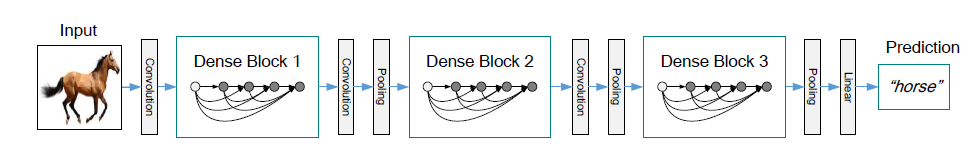

DenseNet은 이전의 모든 layer의 output을 사용하므로 channel 수가 굉장히 많아지게 된다. 이를 해결하기 위해서 DenseNet에서는 각 Layer의 out channel 수로 작은 값을 정하여 사용한다. 이를 growth rate (k) 라고 부르고, 이는 이번 layer의 feature가 전체 네트워크 결과에 얼마나 영향을 미치게 할 것인지를 결정하는 factor이다. 

또한, DenseNet는 ResNet에서 사용했던 Bottleneck구조를  H( )로 이루어진 3x3 conv Layer 이전에 H()로 이루어진 1x1 conv Layer로 구성하여 활용하였다.

DenseNet의 전체 구조는 다음 그림과 같다.

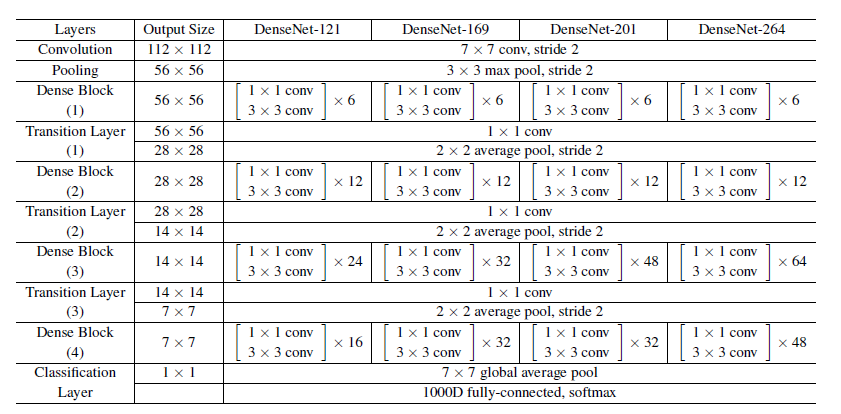

STL10 dataset과 pytorch로 DenseNet 구현하기

In [1]:
# 먼저 필요한 Library import 하기

import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils import data

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 필요한 parameter를 미리 세팅한다.
random_seed=4
learning_rate=0.001
batch_size=32
epochs=101

image_size=224
n_classes=10

DEVICE='cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
datapath='/data'

if not os.path.exists(datapath):
  os.mkdir(datapath)

#transforms로 원하는 형태의 dataset으로 변형해준다.
tfData=transforms.Compose([transforms.Resize((256,256)),
                           transforms.RandomCrop(224),  
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                           ])

# Dataset 다운로드
train_data = datasets.STL10(datapath, split='train', download='True', transform=tfData)
test_data = datasets.STL10(datapath, split='test', download='True', transform=tfData)

print(train_data.data.shape)
print(test_data.data.shape)

train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=False)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /data/stl10_binary.tar.gz to /data
Files already downloaded and verified
(5000, 3, 96, 96)
(8000, 3, 96, 96)


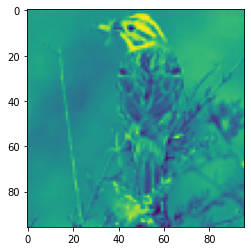

In [3]:
plt.imshow(train_data.data[0][0])

DenseNet 구현하기

DenseNet의 DenseBlock은 BottleNeck으로 구성되어 있으므로, BottleNeck을 정의한다.

In [4]:
class BottleNeck(nn.Module):
  def __init__(self, n_in, growth_rate):  # growth rate만큼 node 수를 확보한다.
    super().__init__()
    
    # Bottleneck은 Batch normalization, ReLU, 1x1 conv인 layer와  BN, ReLU, 3x3 conv인 Layer 두 부분으로 되어 있다.
    # 1x1에 의해 4*growth_rate 만큼의 output이 나오고, 이것이 3x3의 input으로 들어가 growth_rate 만큼의 output이 나온다.
    self.norm1=nn.BatchNorm2d(n_in)
    self.act1=nn.ReLU()
    self.conv1=nn.Conv2d(n_in, 4*growth_rate, kernel_size=1, stride=1, padding=0)
    self.norm2=nn.BatchNorm2d(4*growth_rate)
    self.act2=nn.ReLU()
    self.conv2=nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, stride=1, padding=1)

    self.shortcut=nn.Sequential()  # 이를 들어온 현재 Layer에 들어온 input을 concatenate하기 위해 사용한다. 

  def forward(self, x):
    out=self.norm1(x)
    out=self.act1(out)
    out=self.conv1(out)
    out=self.norm2(out)
    out=self.act2(out)
    out=self.conv2(out)

    out= torch.cat((x, out), 1)  # input인 x와 현재 layer에서 계산된 out을 하나의 Tensor로 만들어줌.

    return out 
  

DenseNet은 DenseBlock을 지난 후, size 감소를 위해 1x1 conv와 average pooling이 포함된 Transition Layer를 사용한다. 이 Transition Layer를 정의한다.

In [5]:
# Dense Block 이후에 1x1 conv와 pooling를 해주는 Layer
class Transition_Layer(nn.Module):
  def __init__(self, n_in, n_out):
    super().__init__()

    self.norm1=nn.BatchNorm2d(n_in)
    self.act1=nn.ReLU()
    self.conv1=nn.Conv2d(n_in, n_out, kernel_size=1)  # 1x1 conv
    self.pool1=nn.AvgPool2d(2, stride=2)  # 2x2 average pooling, stride=2

  def forward(self,x):
    x=self.norm1(x)
    x=self.act1(x)
    x=self.conv1(x)
    x=self.pool1(x)

    return x

위에서 정의한 BottleNeck과 Transition layer를 사용해서 DenseNet을 구성한다.

In [6]:
class DenseNet(nn.Module):
  def __init__(self, bottleNeck, growth_rate, num_blocks, num_classes):
    super().__init__()

    n_in=2*growth_rate  # 논문에서 growth rate의 2배로 정함

    self.conv1=nn.Conv2d(3, n_in, kernel_size=7, stride=2, padding=3)  # rgb 3 (3x224x224)이므로 input=3임
    self.pool1=nn.MaxPool2d(3, stride=2, padding=1)

    # DenseBlock1 & Transition Layer1
    self.block1=self.denseBlock(bottleNeck, n_in, growth_rate, num_blocks[0])
    n_in+=num_blocks[0]*growth_rate  # denseblock 내에서 growth rate만큼 channel수가 증가함
    n_out=int(n_in*0.5)        # Transition Layer에서 Average pooling으로 절반으로 감소함  
    self.trans1=Transition_Layer(n_in, n_out)

    # DenseBlock2 & Transition Layer2
    n_in=n_out
    self.block2=self.denseBlock(bottleNeck, n_in, growth_rate, num_blocks[1])
    n_in+=num_blocks[1]*growth_rate  
    n_out=int(n_in*0.5)         
    self.trans2=Transition_Layer(n_in, n_out)

    # DenseBlock3 & Transition Layer3
    n_in=n_out
    self.block3=self.denseBlock(bottleNeck, n_in, growth_rate, num_blocks[2])
    n_in+=num_blocks[2]*growth_rate  
    n_out=int(n_in*0.5)        
    self.trans3=Transition_Layer(n_in, n_out)

    # DenseBlock4
    n_in=n_out
    self.block4=self.denseBlock(bottleNeck, n_in, growth_rate, num_blocks[3])
    n_in+=num_blocks[3]*growth_rate  
    self.norm1=nn.BatchNorm2d(n_in)   # 마지막 block에서는 transition Layer 대신에 BN, ReLU, 7x7 Global Average Pooling 을 해줘야함
    self.act1=nn.ReLU()
    self.pool2=nn.AvgPool2d(7, stride=1) # 7x7 average pooling

    # Fully connected Layer
    self.fc=nn.Linear(n_in, num_classes)

  # DenseBlock 만들기
  def denseBlock(self, bottleNeck, n_in, growth_rate, num_denseblock):  # Resnet의 residual Layer와 비슷함
    layers=[]
    for i in range(num_denseblock):                 # dense block 내의 bottleNeck 수. 논문에서는 DensNet121은 각 block에 따라 6,12,24,16 개임
      layers.append(bottleNeck(n_in, growth_rate))  # bottleNeck을 이용해서 Dense Block 생성함
      n_in+=growth_rate
    return nn.Sequential(*layers)

  def forward(self, x):
    x=self.conv1(x)
    x=self.pool1(x)
    x=self.block1(x)
    x=self.trans1(x)
    x=self.block2(x)
    x=self.trans2(x)
    x=self.block3(x)
    x=self.trans3(x)
    x=self.block4(x)
    x=self.norm1(x)
    x=self.act1(x)
    x=self.pool2(x)

    x=x.view(x.size(0), -1)
    x=self.fc(x)

    return x



DenseNet121을 사용하였다.

In [7]:
model=DenseNet(BottleNeck, growth_rate=12, num_blocks=[6, 12, 24, 16], num_classes=10).to(DEVICE)
print(model)

DenseNet(
  (conv1): Conv2d(3, 24, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (block1): Sequential(
    (0): BottleNeck(
      (norm1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1))
      (norm2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU()
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
    )
    (1): BottleNeck(
      (norm1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1))
      (norm2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU()
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), 

In [8]:
from torchsummary import summary
summary(model, input_size=(3,224,224))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]           3,552
         MaxPool2d-2           [-1, 24, 56, 56]               0
       BatchNorm2d-3           [-1, 24, 56, 56]              48
              ReLU-4           [-1, 24, 56, 56]               0
            Conv2d-5           [-1, 48, 56, 56]           1,200
       BatchNorm2d-6           [-1, 48, 56, 56]              96
              ReLU-7           [-1, 48, 56, 56]               0
            Conv2d-8           [-1, 12, 56, 56]           5,196
        BottleNeck-9           [-1, 36, 56, 56]               0
      BatchNorm2d-10           [-1, 36, 56, 56]              72
             ReLU-11           [-1, 36, 56, 56]               0
           Conv2d-12           [-1, 48, 56, 56]           1,776
      BatchNorm2d-13           [-1, 48, 56, 56]              96
             ReLU-14           [-1, 48,

Train

In [9]:
optimizer=optim.Adam(model.parameters(), lr=learning_rate)
criterion=nn.CrossEntropyLoss()

train data를 가지고 학습하는 단계

In [10]:
def train(train_loader, model, criterion, optimizer, device):

  running_loss=0
  count=0
  correct=0

  model.train()
  for batch in train_loader:
    X=batch[0]
    y_true=batch[1]

    X=X.to(device)
    y_true=y_true.to(device)   

    # Forward
    y_pred=model(X)
    loss=criterion(y_pred, y_true)
    running_loss+=loss.item()
    batch_correct=torch.argmax(y_pred, dim=1).eq(y_true).sum().item()
    batch_count=len(X)


    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    count+=batch_count
    correct+=batch_correct
  
  epoch_loss=running_loss / len(train_loader.dataset)
  epoch_accuracy=correct/count
  return model, optimizer, epoch_loss, epoch_accuracy   

test data를 가지고 학습된 model에 적용함

In [11]:
def evaluation(test_loader, model, criterion, device):

  running_loss=0
  count=0
  correct=0
  
  model.eval()
  for batch in test_loader:
    X=batch[0]
    y_true=batch[1]

    X=X.to(device)
    y_true=y_true.to(device)

    # Forward
    y_pred=model(X)
    loss=criterion(y_pred, y_true)
    batch_correct=torch.argmax(y_pred, dim=1).eq(y_true).sum().item()
    batch_count=len(X)
    running_loss+=loss.item()*X.size(0)

    count+=batch_count
    correct+=batch_correct


  epoch_loss=running_loss/len(test_loader.dataset)
  epoch_accuracy=correct/count  

  return model, epoch_loss, epoch_accuracy

In [12]:
# train % validation

train_losses=[]
test_losses=[]

train_acc=[]
test_acc=[]
for epoch in range(epochs):
  model, optimizer, train_loss, train_accuracy=train(train_loader, model, criterion, optimizer, DEVICE)
  train_acc.append(train_accuracy)
  train_losses.append(train_loss)

  with torch.no_grad():
     model, test_loss, test_accuracy=evaluation(test_loader, model, criterion, DEVICE)
     test_acc.append(test_accuracy)
     test_losses.append(test_loss)

  if epoch%10==0:
      print('epoch: ', epoch, 'train_loss: ', train_loss, 'test_loss: ', test_loss)
      print('          train accuracy: ', train_accuracy, 'test accuracy: ', test_accuracy)

epoch:  0 train_loss:  0.05631941294670105 test_loss:  1.8383848395347595
          train accuracy:  0.294 test accuracy:  0.30975
epoch:  10 train_loss:  0.028002202904224397 test_loss:  1.1313830416202546
          train accuracy:  0.6774 test accuracy:  0.6065
epoch:  20 train_loss:  0.016158805125951768 test_loss:  1.0338796291351318
          train accuracy:  0.8134 test accuracy:  0.668375
epoch:  30 train_loss:  0.009254966375231743 test_loss:  1.0833953572511672
          train accuracy:  0.8942 test accuracy:  0.700125
epoch:  40 train_loss:  0.004244420930370688 test_loss:  1.0444793209433556
          train accuracy:  0.9518 test accuracy:  0.738125
epoch:  50 train_loss:  0.0036079520650207997 test_loss:  1.16564273583889
          train accuracy:  0.9614 test accuracy:  0.730875
epoch:  60 train_loss:  0.0030773754739202557 test_loss:  1.2832372770309448
          train accuracy:  0.9684 test accuracy:  0.72375
epoch:  70 train_loss:  0.002747421973058954 test_loss:  1.267

DenseNet의 경우 ResNet보다 수렴이 더 빨리 이루어졌고, 그에 따른 100 epoch에서의 정확도도 더 높게 나왔다.
Train set은 98%, test set은 73%가 나왔다

참고

https://github.com/bamos/densenet.pytorch/blob/master/densenet.py